In [2]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from operator import itemgetter
import lmfit
from scipy import signal
from scipy import fftpack
from skimage import util
import operator
from numpy import NaN, Inf, arange, isscalar, asarray, array
import pylab
import inspect

run = ['001','002','003','004','005','006','007','008','009','010',
       '011','012','013','014','015','016','017','018','019','020', 
       '021','022','023','024','025','026','027','028','029','030',
       '031','032','033','034','035','036','037','038','039','040',
       '041','042','043','044','045','046','047','048','049','050',
       '051','052','053','054','055','056','057','058','059','060',
       '061','062','063','064','065','066','067','068','069','070',
       '071','072','073','074','075','076','077','078','079','080',
       '081','082','083','084','085','086','087','088','089','090',
       '091','092','093','094','095','096','097','098','099','100']

kx_ind = np.linspace(0.007, 0.1, 32)

##############################################################################################################
###############################################    FUNCTIONS     #############################################
##############################################################################################################


#############################################    PEAK DETECTOR     ###########################################

def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

#############################################    FITTING MODEL     ###########################################

def model(t, decay):  # , omega, resid):
    return np.exp(-t/decay)  # * np.cos(omega * t) + resid
gmodel = lmfit.Model(model)

#############################################    DIAGNOSTIC TOOL     ###########################################

def diag_w7x(filename, minlim=None, maxlim=None, spectrogram=False, plot=False, my_data=None, k=None, kx_m=None, nkx0=None):
    
    kx_ind = np.linspace((kx_m), (kx_m)*(nkx0), (nkx0))
    
    if maxlim is not None and minlim is None:
        nummy = run[0:maxlim]
        if k is not None:
            kx = kx_ind[k:(maxlim+k)]
        else:
            kx = kx_ind[0:maxlim]
    elif minlim is not None and maxlim is None:
        nummy = run[minlim:len(run)]
        kx = kx_ind[minlim:len(run)]
    elif minlim is not None and maxlim is not None:
        nummy = run[minlim:maxlim]
        if k is not None:
            kx = kx_ind[(k+minlim):(maxlim+k)]
        else:
            kx = kx_ind[minlim:maxlim]
    if minlim is None and maxlim is None:
        nummy = run
        kx = kx_ind  
    
    dataset = [('./{0}/GAMDIAGions_0{1}.dat'.format(filename, index), index) for index in nummy]     
    datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array

    if plot == True and type(my_data) == type(None):
        plt.figure(figsize=(13, 6.5))
        plt.axhline(y=0, color='black', linestyle='dashed')
        plt.title("{0}".format(filename), fontsize=30)
        #plt.xscale('log')
        plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
        plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)
    
    if type(my_data) == type(None):
        integ = []
        rmsvl = []
        decay = []
        osrat = []
        burat = []
        g1rat = []
        g2rat = []
        dcrat = []
        perid = []
        perbd = []
        pekti = []
    else:
        integ = my_data[0, :].tolist()
        rmsvl = my_data[1, :].tolist()
        decay = my_data[2, :].tolist()
        osrat = my_data[3, :].tolist()
        burat = my_data[4, :].tolist()
        g1rat = my_data[5, :].tolist()
        g2rat = my_data[6, :].tolist()
        dcrat = my_data[7, :].tolist()
        perid = my_data[8, :].tolist()
        perbd = my_data[9, :].tolist()
        pekti = my_data[10, :].tolist()
    n = 0
    for data, label in datalist:
        #plt.figure(figsize=(13, 6.5))
        #plt.axhline(y=0, color='black', linestyle='dashed')
        #plt.title('W7-X Standard Config. s06', fontsize=30)
        ##plt.xscale('log')
        #plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
        #plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)
        #plt.ylim([-0.3, 1.6])
        #plt.xlim([0, 500])
        E = (data[:,1]*(1/data[0, 1]))
        t = data[:,0]
        
        if plot == True:
            plt.plot(t, E, label='{0}'.format(label))
            #plt.text(350, 0.5, 'kx: {0}'.format(round(kx_ind[0+n], 4)), fontsize=14)
            if len(nummy) > 1100:
                plt.legend(kx, title='$k_{x}$', fontsize=14)
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        intefield = np.trapz(E, t)
        integ.append(intefield)
        rms = np.sqrt(np.mean(E**2))
        rmsvl.append(rms)
        
        result, OS, BR, GR1, GR2, DR, PE, PE2, TP = nucleus_w7x(E, t, label, diag=False)   
        
        decay.append(result.best_values.get('decay'))
        osrat.append(OS)
        burat.append(BR)
        g1rat.append(GR1)
        g2rat.append(GR2)
        dcrat.append(DR)
        perid.append(PE)
        perbd.append(PE2)
        pekti.append(TP)
        #plt.savefig('{0}.png'.format(label), format='png', dpi=250)
        n = n+1
        
    if type(my_data) != type(None):
        plt.show()
    
        if spectrogram == True:
            ########  SPECTROGRAM
            f_s = len(data[:, 0]) / data[-1, 0]
            E = (data[:,1]*(1/data[0, 1]))
            M = 1024
            slices = util.view_as_windows(E, window_shape=(M,), step=2)
            win = np.hanning(M + 1)[:-1]
            slices = slices * win
            slices = slices.T
            spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
            spectrum = np.abs(spectrum)
            S = np.abs(spectrum)
            S = 20 * np.log10(S / np.max(S))
            plt.figure()
            plt.imshow(S, origin='lower', cmap='viridis')
            plt.title(str(label), fontsize=30)
            plt.axis('tight')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time ($a / v_{ti}$)')
            #plt.ylim([0, 0.3])

    f_s = len(data[:, 0]) / data[-1, 0]
    my_data = np.array([integ, rmsvl, decay, osrat, burat, g1rat, g2rat, dcrat, perid, perbd, pekti])
    return kx, my_data, E, t, f_s, label

#############################################    DIAGNOSTIC PLOTTER     ###########################################

def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

def diag_plotter(kx, my_data, alldata=False, fig=True):
    
    integ = my_data[0, :]
    rmsvl = my_data[1, :]
    decay = my_data[2, :]
    osrat = my_data[3, :]
    burat = my_data[4, :]
    g1rat = my_data[5, :]
    g2rat = my_data[6, :]
    dcrat = my_data[7, :]
    perid = my_data[8, :]
    perbd = my_data[9, :]
    pekti = my_data[10, :]
    
    if fig == True:
        fig = plt.figure(figsize=(30, 20))
    else:
        fig = fig
        
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    ax4 = fig.add_subplot(334)
    ax5 = fig.add_subplot(335)
    ax6 = fig.add_subplot(336)
    ax7 = fig.add_subplot(337)
    ax8 = fig.add_subplot(338)
    ax9 = fig.add_subplot(339)


    ########  top
    ax1.plot(kx, integ)
    ax2.plot(kx, rmsvl)
    ax3.plot(kx, decay)
    
    #ax1.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax2.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax3.set_xlabel('$k_{x} \\rho_{ti}$')

    ax1.title.set_text('Integral')
    ax2.title.set_text('RMS value')
    ax3.title.set_text('Decay length')

    ########  mid
    ax4.plot(kx, osrat)
    ax5.plot(kx, g2rat, label='Growth ratio')
    ax5.plot(kx, dcrat, label='Decay ratio')
    ax6.plot(kx, pekti, label='{0}'.format(retrieve_name(my_data)))
    
    #ax4.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax5.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax6.set_xlabel('$k_{x} \\rho_{ti}$')
    
    ax4.title.set_text('Overshoot ratio')
    # ax5.title.set_text('')
    ax6.title.set_text('Peak time')
    ax6.legend(loc="upper right")
    ax5.legend(loc="lower right")
    
    ########  bottom
    #ax3.title.set_text('RMS')
    ax7.plot(kx, g1rat)
    ax8.plot(kx, burat)
    ax9.plot(kx, perid, label='Decay Period')
    ax9.plot(kx, perbd, label='Bump Period')
    
    ax7.title.set_text('Bump growth ratio')
    ax8.title.set_text('Bump ratio')
    # ax9.title.set_text('Period')
    ax9.legend(loc="upper right")
    
    ax7.set_xlabel('$k_{x} \\rho_{ti}$')
    ax8.set_xlabel('$k_{x} \\rho_{ti}$')
    ax9.set_xlabel('$k_{x} \\rho_{ti}$')

    if alldata == False:
        fig.show()

    return fig
#############################################    TROUBLESHOOTER     #############################################
def troubleshooter(E, t, f_s, label, spectrogram=True):
    X = fftpack.fft(E)
    freqs = fftpack.fftfreq(len(E)) * f_s

    fig = plt.figure(figsize=(13, 13))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.stem(freqs, np.abs(X))
    ax1.set_xlabel('Frequency in Hertz [Hz]')
    ax1.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    ax1.set_xlim(0, 0.55)  # f_s / 2)
    #ax2.set_ylim(-2, 2)
    ax2.set_xlim(0, 500)
    ax2.plot(t, E, label='{0}'.format(label))
    ax2.axhline(y=0, color='black', linestyle='dashed')
    
    maxtab, mintab, OS, BR, GR1, GR2, DR, PE, PE2, TP, a, b1, b2, e, i, o = nucleus_w7x(E, t, label, diag=True)
    
    if type(b1) == float and type(o) != float:
        n = ['a', 'e', 'i', 'o']
        x = np.array([a, e, i, o])[:,1]
        y = np.array([a, e, i, o])[:,0]
    elif type(b1) != float and type(o) == float:
        n = ['a', 'b1', 'b2', 'e', 'i']
        x = np.array([a, b1, b2, e, i])[:,1]
        y = np.array([a, b1, b2, e, i])[:,0]
    else:
        n = ['a', 'b1', 'b2', 'e', 'i', 'o']
        x = np.array([a, b1, b2, e, i, o])[:,1]
        y = np.array([a, b1, b2, e, i, o])[:,0]
    ax2.scatter(y,x, color='blue')
    for r, txt in enumerate(n):
        ax2.annotate(txt, (y[r], x[r]))
    ax2.scatter(e[0], e[1], color='green')
    ax2.scatter(maxtab[:, 0], maxtab[:, 1], color='red')
    ax2.scatter(mintab[:, 0], mintab[:, 1], color='blue')
    #ax2.set_xlim(-10, 100)
    print('Overshoot ratio (OS): ' + str(OS))
    print('Bump ratio (BR): ' + str(BR))
    print('Bump growth ratio (GR1): ' + str(GR1))
    print('2nd growth ratio (GR2): ' + str(GR2))
    print('Period (PE): ' + str(PE))
    print('Peak time (TP): ' + str(TP))
    fig.show()
    
    if spectrogram == True:
            ########  SPECTROGRAM
            M = 1024
            slices = util.view_as_windows(E, window_shape=(M,), step=2)
            win = np.hanning(M + 1)[:-1]
            slices = slices * win
            slices = slices.T
            spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
            spectrum = np.abs(spectrum)
            S = np.abs(spectrum)
            S = 20 * np.log10(S / np.max(S))
            plt.figure(figsize=(13, 6.5))
            plt.imshow(S, origin='lower', cmap='viridis')
            plt.title(str(label), fontsize=30)
            plt.axis('tight')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time ($a / v_{ti}$)')
            plt.ylim([0, 100])
    plt.show()
    
    return 
    

In [3]:
def nucleus_w7x(E, t, label, diag=False):
    # Peak detection
    maxtab, mintab = peakdet(E, 0.001, x=t)
    
    # A fitting to the peak values to get the decay coefficient:
    result = gmodel.fit(E[:150], t=t[:150], decay=10, nan_policy='propagate')

    # Can you guess the residual?
    if 0.95 <= np.abs(E[-1]/mintab[0, 1]) <= 1.02:
        print('residual? :' + str(mindec[0, 1]))
        
    # Maxpeaks
    a = maxtab[0, :]  # Initial point
    
    if np.shape(maxtab) != (2, 2):  # If there are more points than a and i:
        b1 = maxtab[1, :]  # Second Peak
        i = maxtab[2, :]            
    elif np.shape(maxtab) == (2, 2):
        i = maxtab[1, :]
        b1 = i
        print('i point is the first one')     
    
    # Minpeaks
    b2 = mintab[0, :]  # (Technically) The lowest point
        
    min_index, min_value = min(enumerate(mintab[:, 1]), key=operator.itemgetter(1))  
    f = mintab[min_index, :]  # This determines the minimum peak
    
    if np.shape(mintab) != (1, 2):
        e = mintab[1, :]
    else:
        e = f

    # The initial bump is not detected if the points e & i are both > 0.32
    if b1[0] > 60:
        i = b1
        if i[1] < 0:
            i = maxtab[2, :]
        e = b2
        b1, b2, BR = np.nan, np.nan, np.nan
        GR1, GR2, PE2 = np.nan, np.nan, np.nan
    else:
        BR = np.abs(b2[1] / a[1])                      # Bump ratio
        GR1 = np.abs((e[1]-a[1]) / (b2[1]-a[1]))       # Bump growth ratio
        GR2 = np.abs(e[1] / b2[1])                     # Growth ratio
        PE2 = np.abs(e[0] - b2[0])                     # Bump period

    if isinstance(b2, float) and np.shape(mintab) != (1, 2):  # if b2 does not exist and mintab has more than 1 point
        o = mintab[1, :]
        if o[0] < i[0]:
            o = mintab[2, :]
        DR = np.abs(o[1] / e[1])                       # Decay ratio
        PE = np.abs(o[0] - e[0])                       # Decay period
    elif isinstance(b2, float) == False and np.shape(mintab)[0] >=3:  # if b2 exists and the shape of mintab is >=3
        o = mintab[2, :]
        DR = np.abs(o[1] / e[1])  # Decay ratio
        PE = np.abs(o[0] - e[0])  # Decay period
    else:
        o = np.nan
        DR = np.nan  # Decay ratio
        PE = np.nan  # Decay period

    TP = e[0]                                          # Peak time
    OS = np.abs(e[1] / a[1])                           # Overshoot ratio
            
    if diag == True:
        print('Diag mode on')
        
        return maxtab, mintab, OS, BR, GR1, GR2, DR, PE, PE2, TP, a, b1, b2, e, i, o
    else:

        return result, OS, BR, GR1, GR2, DR, PE, PE2, TP

In [4]:
kx_32, my_data_g32, E, t, f_s, label = diag_w7x('alm32', maxlim=32, plot=True, k_num=32)
kx_32, my_data_a32, E, t, f_s, label = diag_w7x('gam32', maxlim=32, plot=True, k_num=32)
kx_16, my_data_a16, E, t, f_s, label = diag_w7x('alm16', maxlim=16, plot=True, k_num=16)
kx_16, my_data_g16, E, t, f_s, label = diag_w7x('gam16', maxlim=16, plot=True, k_num=16)
kekdata = my_data_g32, my_data_a32, my_data_a16, my_data_g16
kx = kx_32, kx_32, kx_16, kx_16
for d in range(0, 4):
    if retrieve_name(kekdata[d]) == retrieve_name(my_data_g32):
        fig = diag_plotter(kx[d], kekdata[d], alldata=True, fig=True)
    else:
        fig = diag_plotter(kx[d], kekdata[d], alldata=True, fig=fig)
    print(retrieve_name(kekdata[d]))
plt.show()

TypeError: diag_w7x() got an unexpected keyword argument 'k_num'

In [ ]:
troubleshooter(E, t, f_s, label, spectrogram=True)

i point is the first one
i point is the first one
i point is the first one
i point is the first one


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


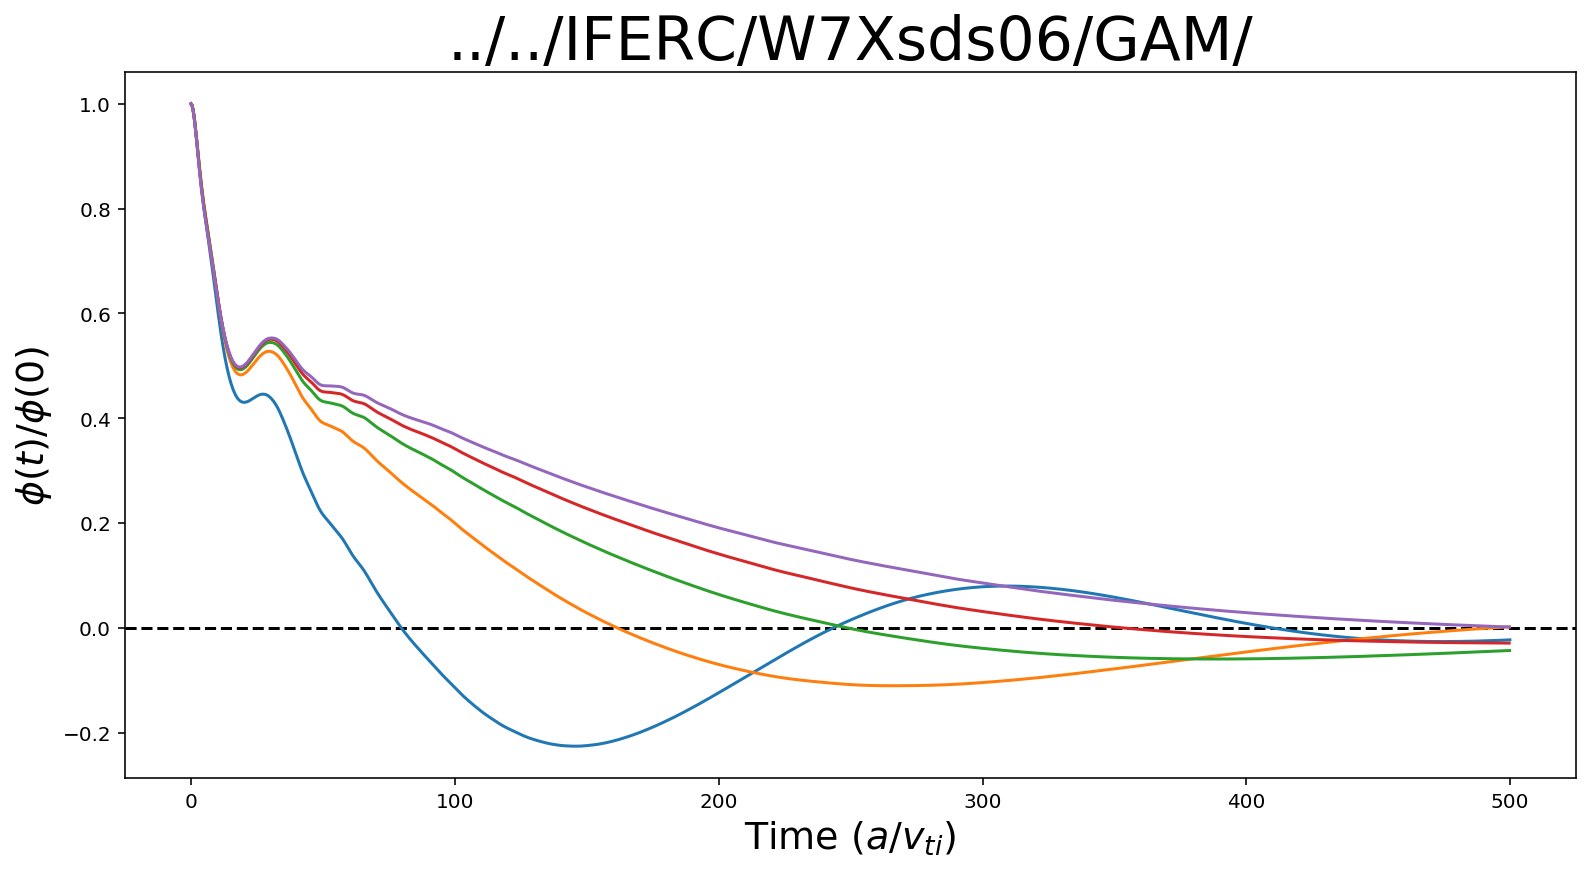

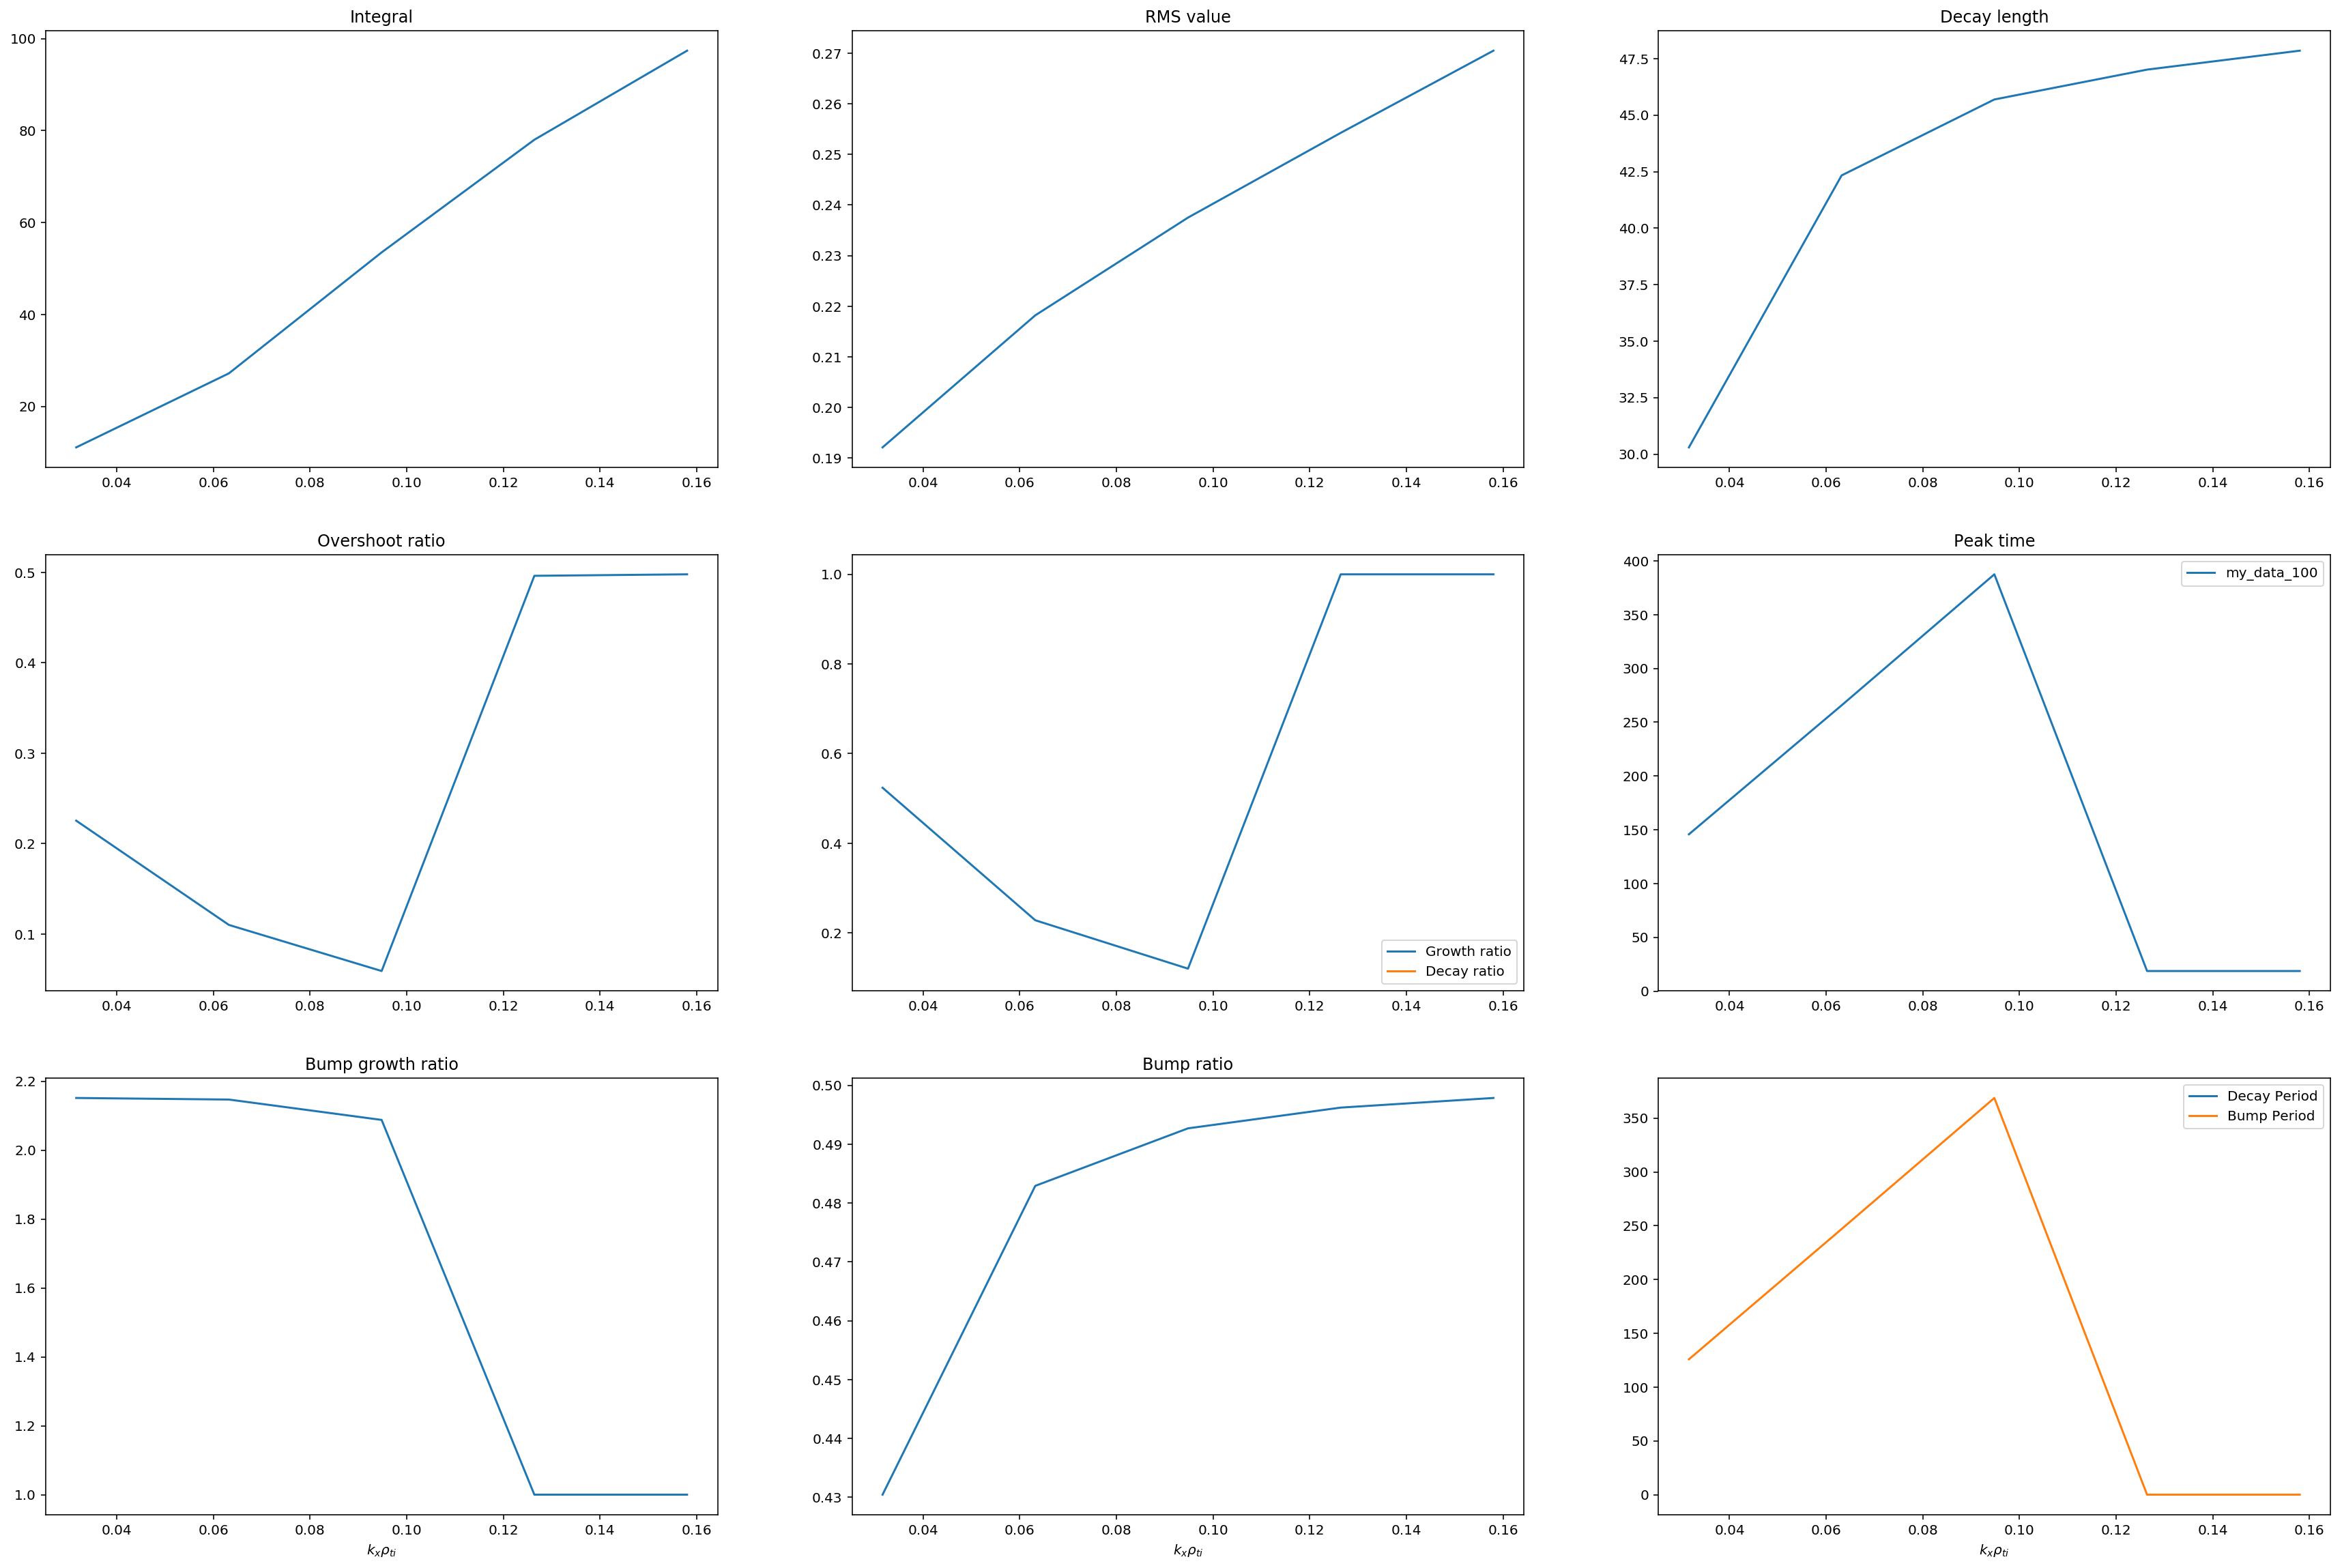

In [5]:
kx_100, my_data_100, E, t, f_s, label = diag_w7x('../../IFERC/W7Xsds06/GAM/', minlim=0, maxlim=5, plot=True, kx_m=0.0316, nkx0=90)
fig = diag_plotter(kx_100, my_data_100, alldata=False, fig=True)

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


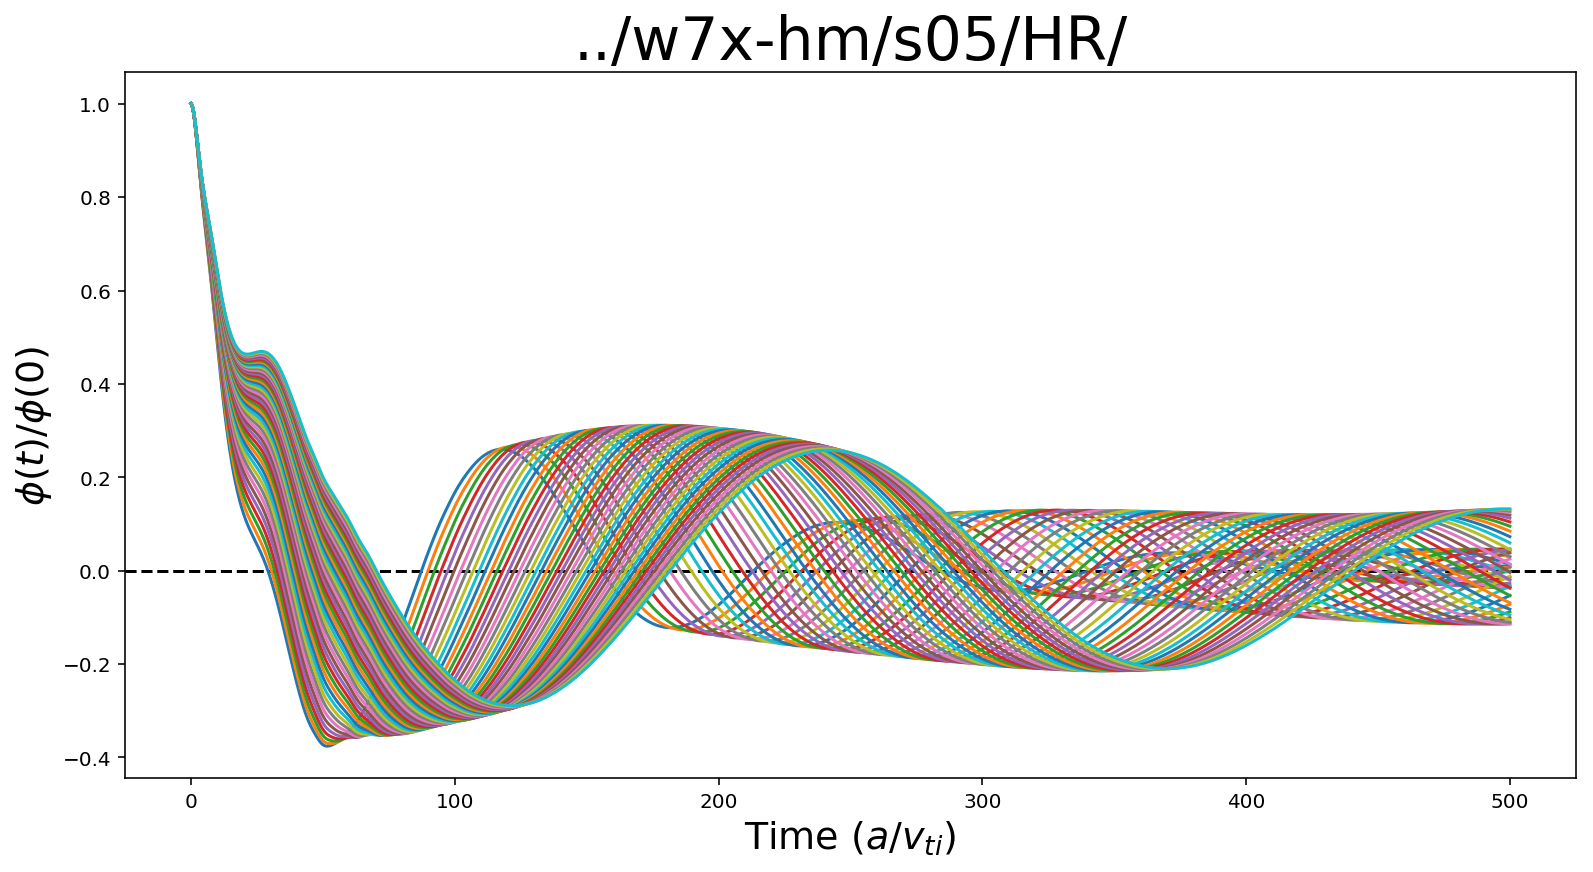

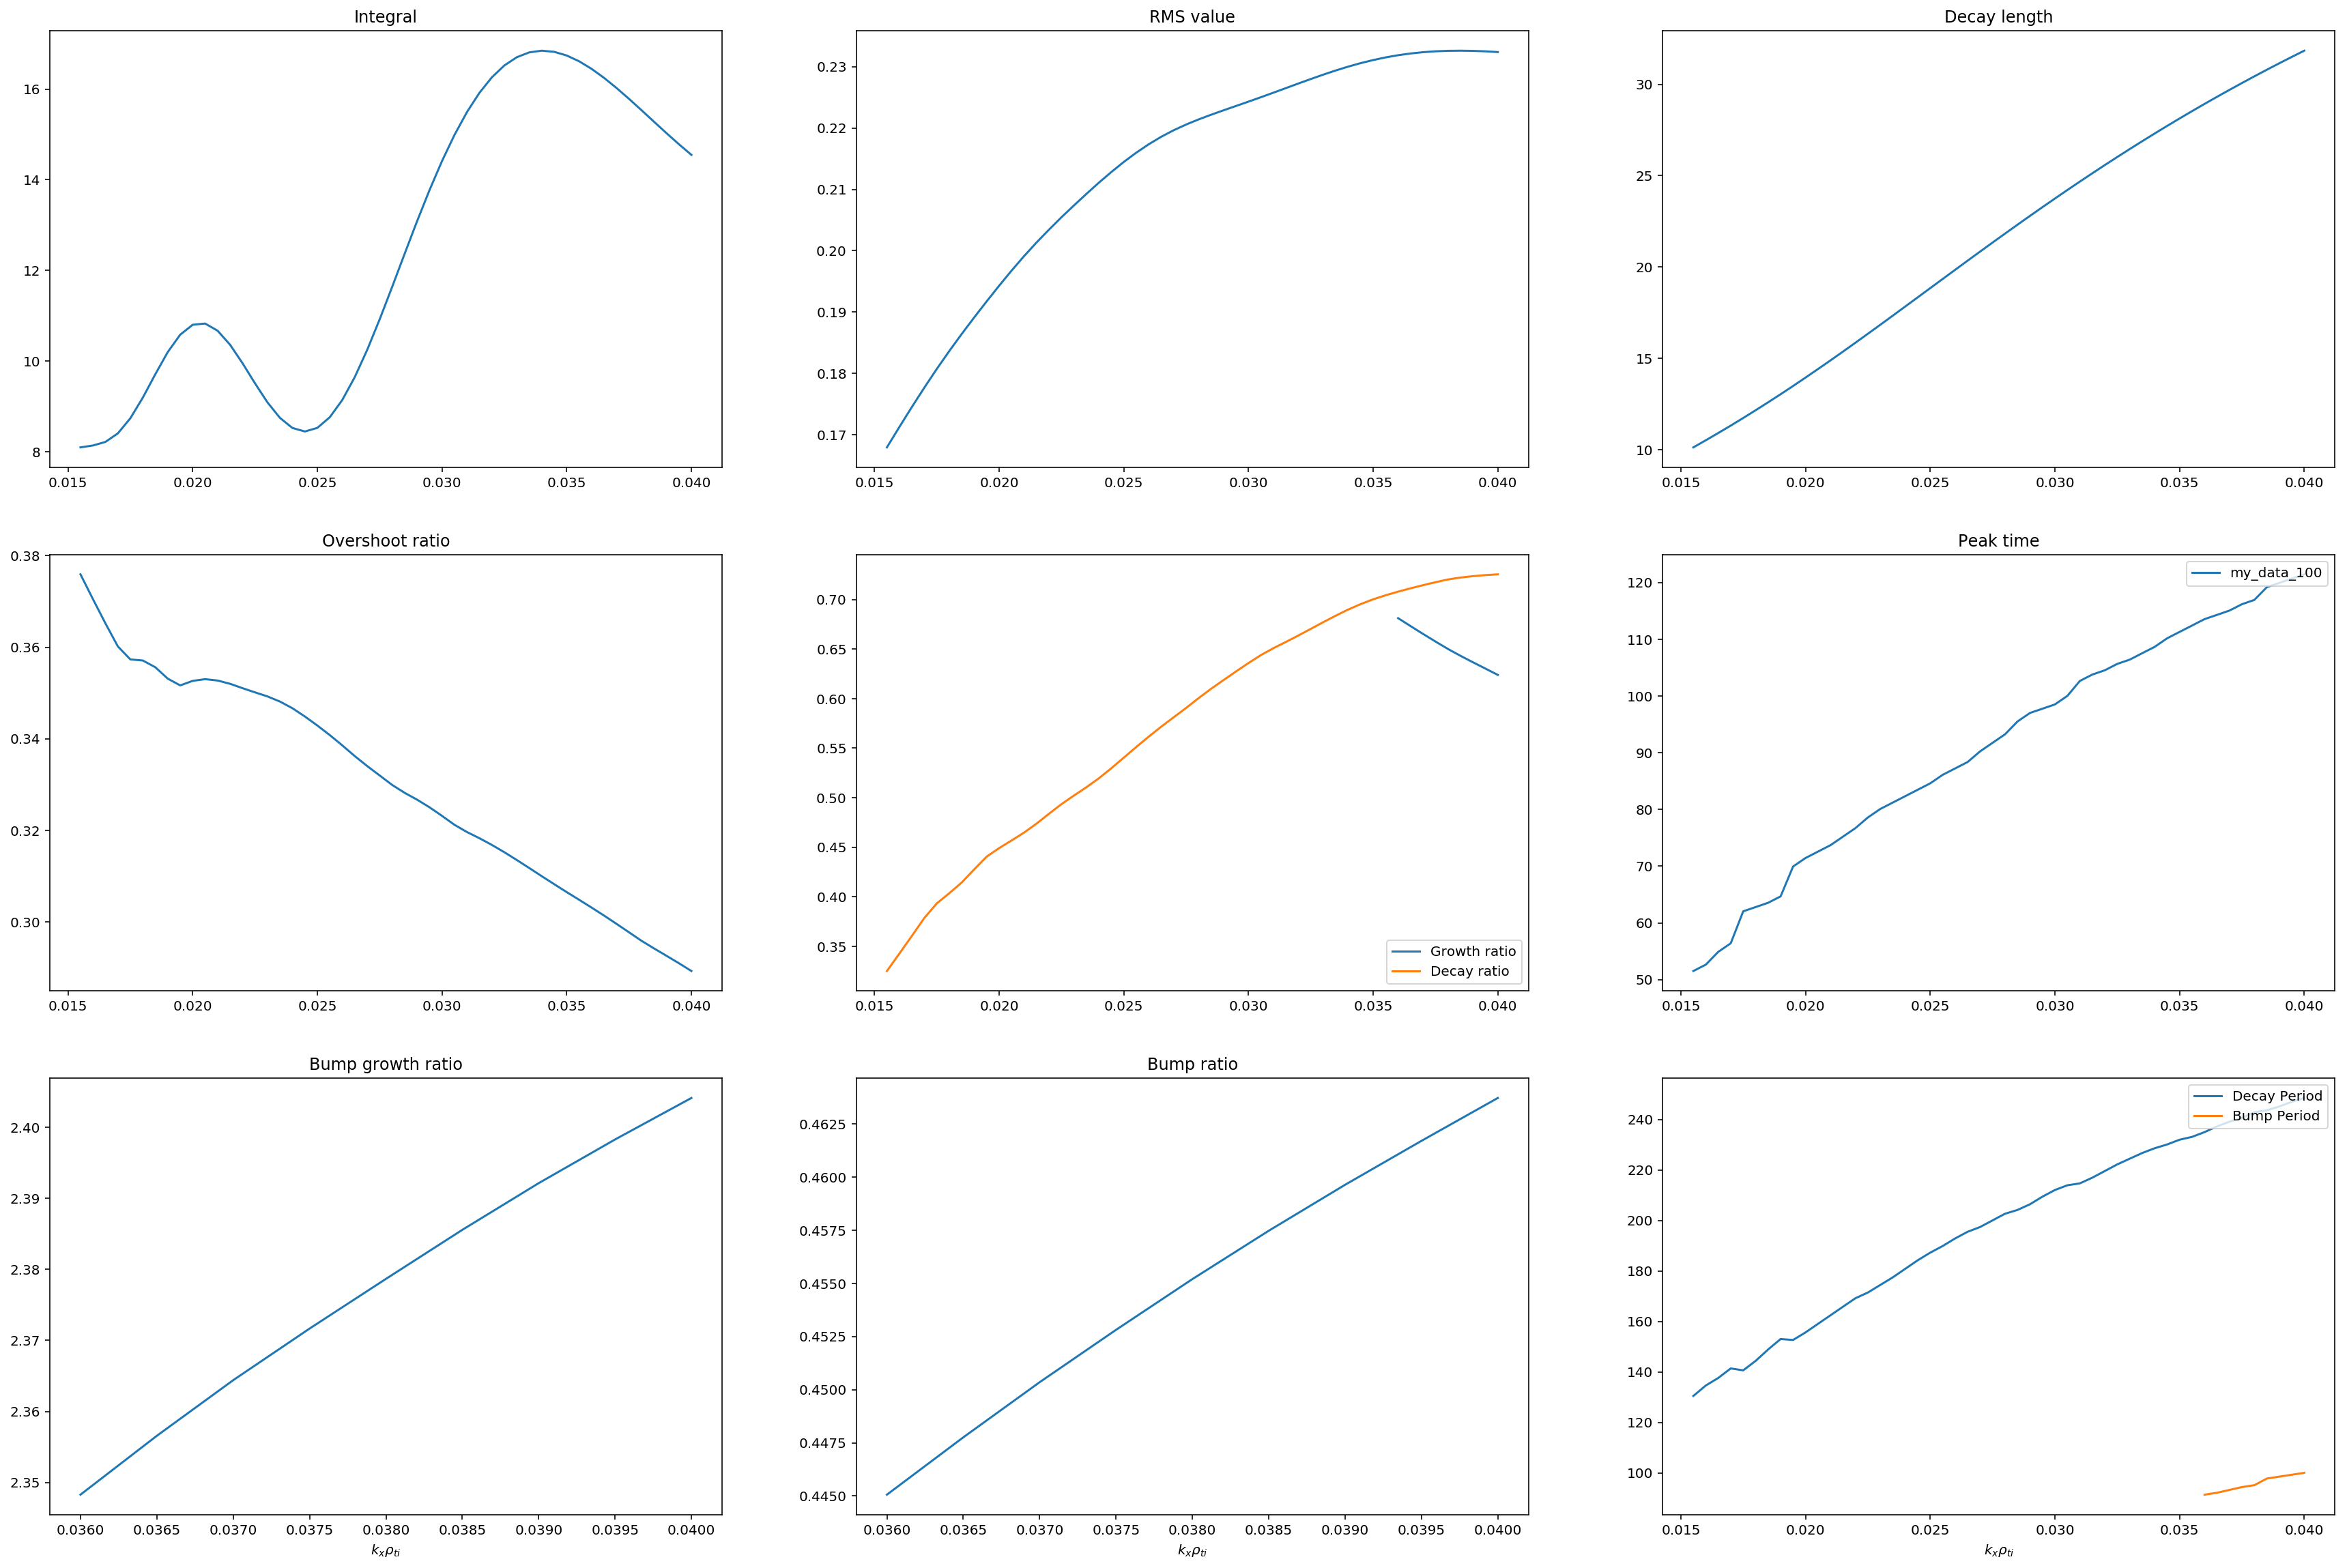

In [6]:
kx_100, my_data_100, E, t, f_s, label = diag_w7x('../w7x-hm/s05/HR/', minlim=30, maxlim=80, plot=True, kx_m=0.0005, nkx0=100)
fig = diag_plotter(kx_100, my_data_100, alldata=False, fig=True)

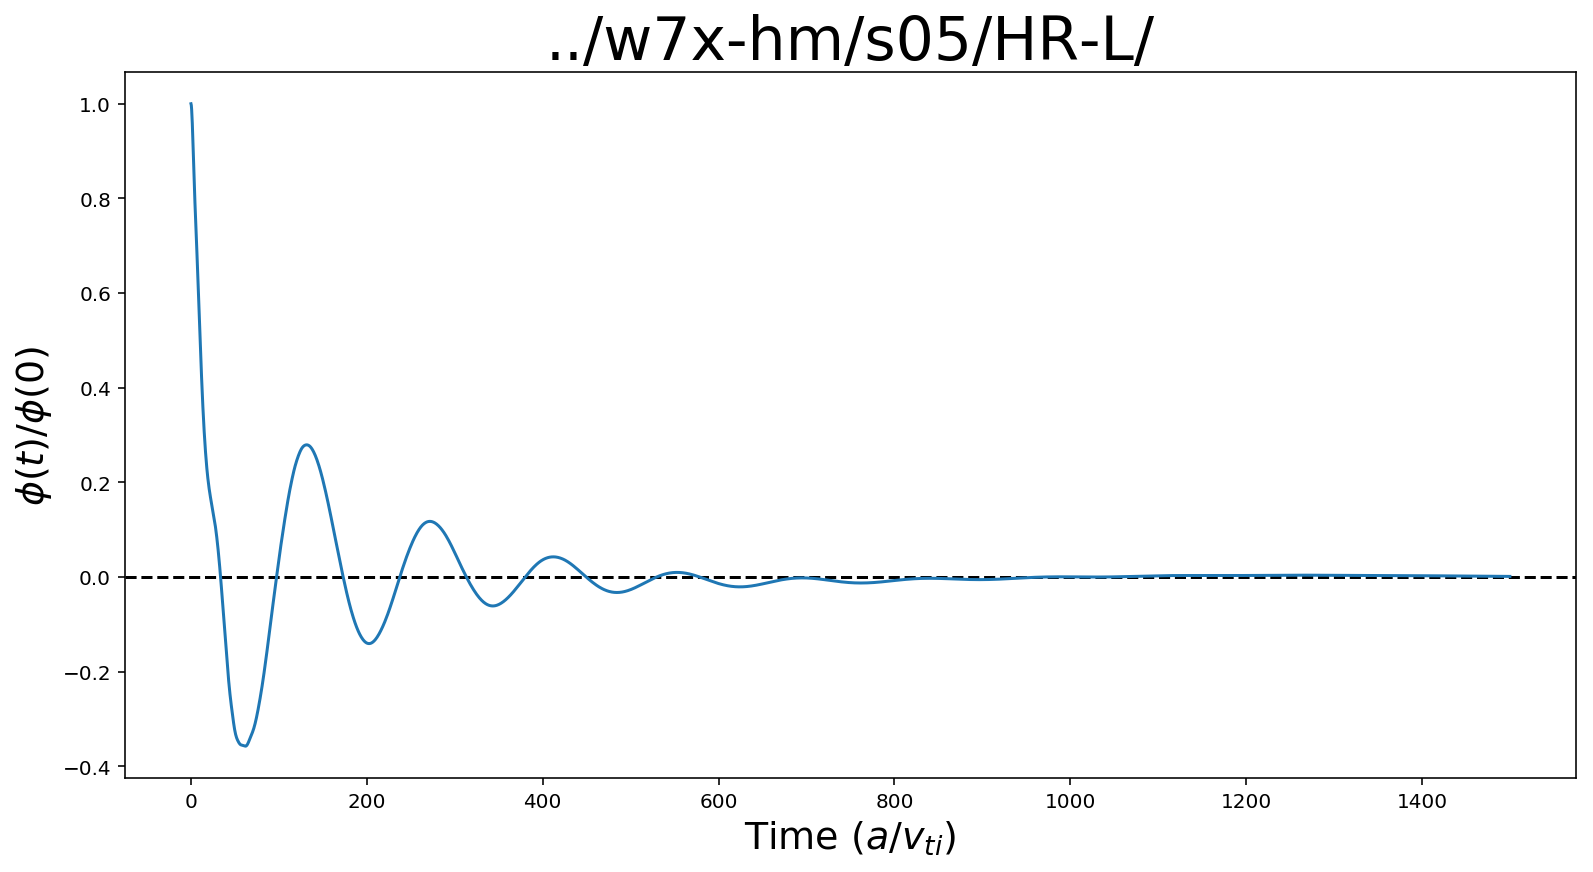

In [7]:
kx_100, my_data_100, E, t, f_s, label = diag_w7x('../w7x-hm/s05/HR-L/', minlim=34, maxlim=35, plot=True, kx_m=0.0005, nkx0=100)
#fig = diag_plotter(kx_100, my_data_100, alldata=False, fig=True)

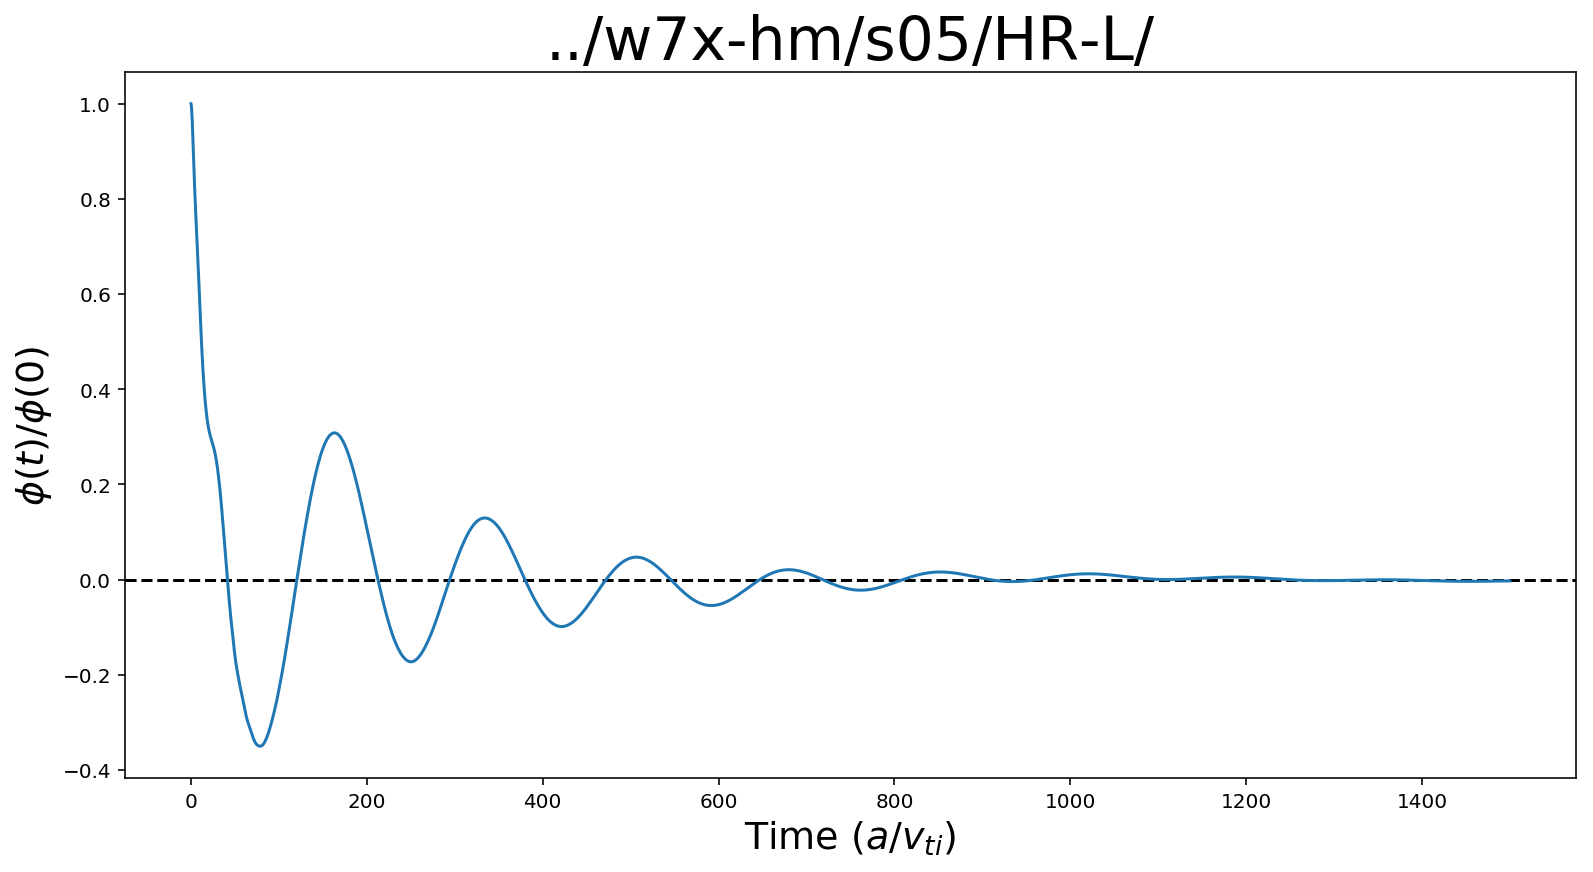

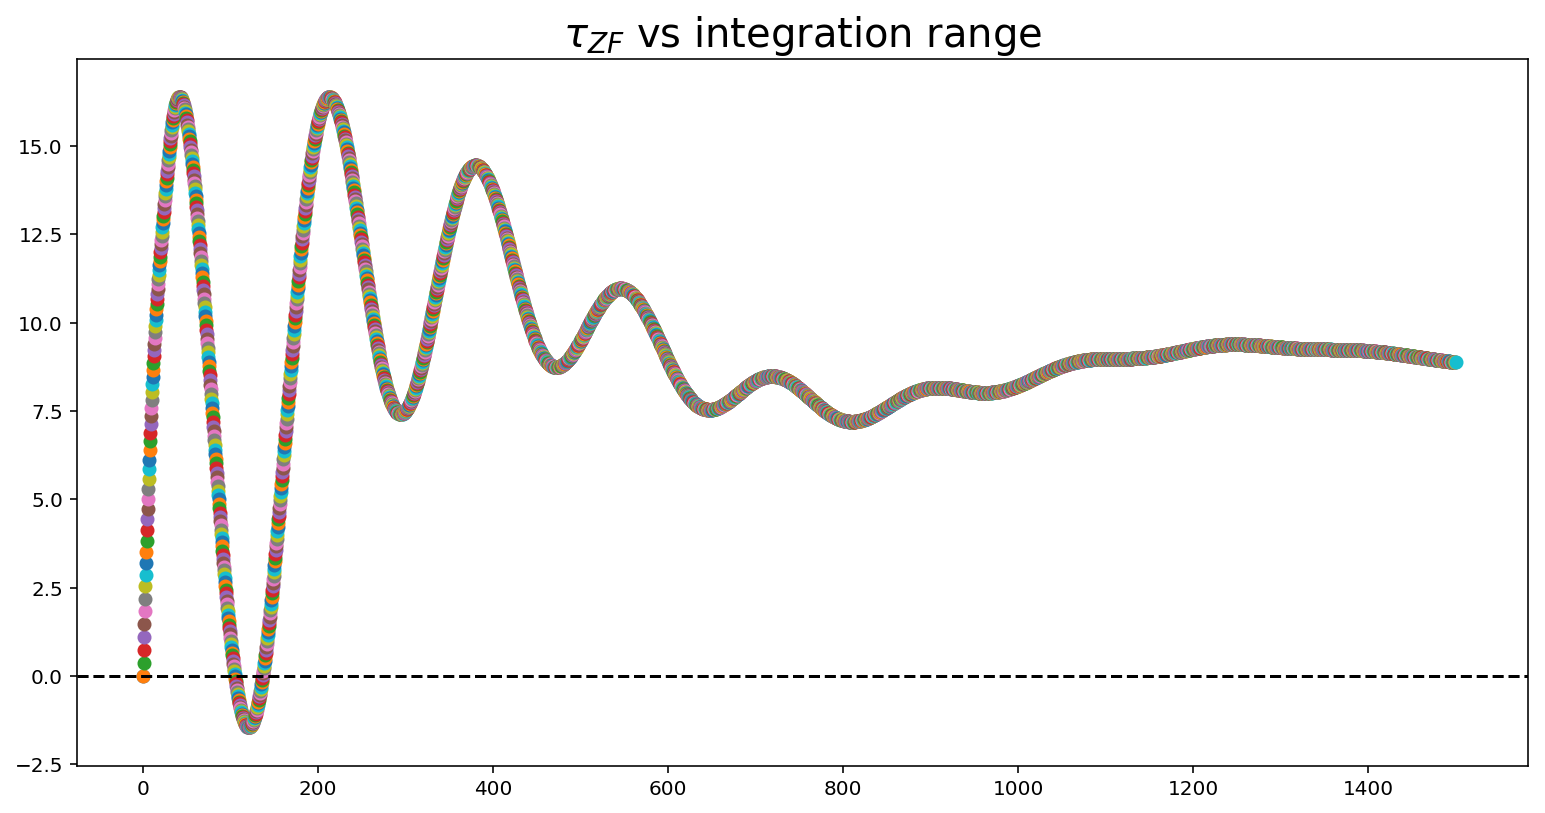

In [8]:
kx_100, my_data_100, E, t, f_s, label = diag_w7x('../w7x-hm/s05/HR-L/', minlim=44, maxlim=45, plot=True, kx_m=0.0005, nkx0=100)
plt.figure(figsize=(13, 6.5))
plt.title("$\\tau_{ZF}$ vs integration range", fontsize=20)
for n in range(len(E)):
    intefield = np.trapz(E[:n], t[:n])
    plt.scatter(t[n], intefield)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.show()

In [9]:
import os,sys
import datetime
import imageio
from pprint import pprint
import time
import datetime
e=sys.exit
 
 
def create_gif(filenames, duration):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename, pilmode='RGB'))
    output_file = 'Gif-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave(output_file, images, fps=5)
 
 
if __name__ == "__main__":
    duration = 0.2 
    filenames = sorted(filter(os.path.isfile, [x for x in os.listdir() if x.endswith(".png")]), key=lambda p: os.path.exists(p) and os.stat(p).st_mtime or time.mktime(datetime.now().timetuple()))
 
    create_gif(filenames, duration)

RuntimeError: Zero images were written.

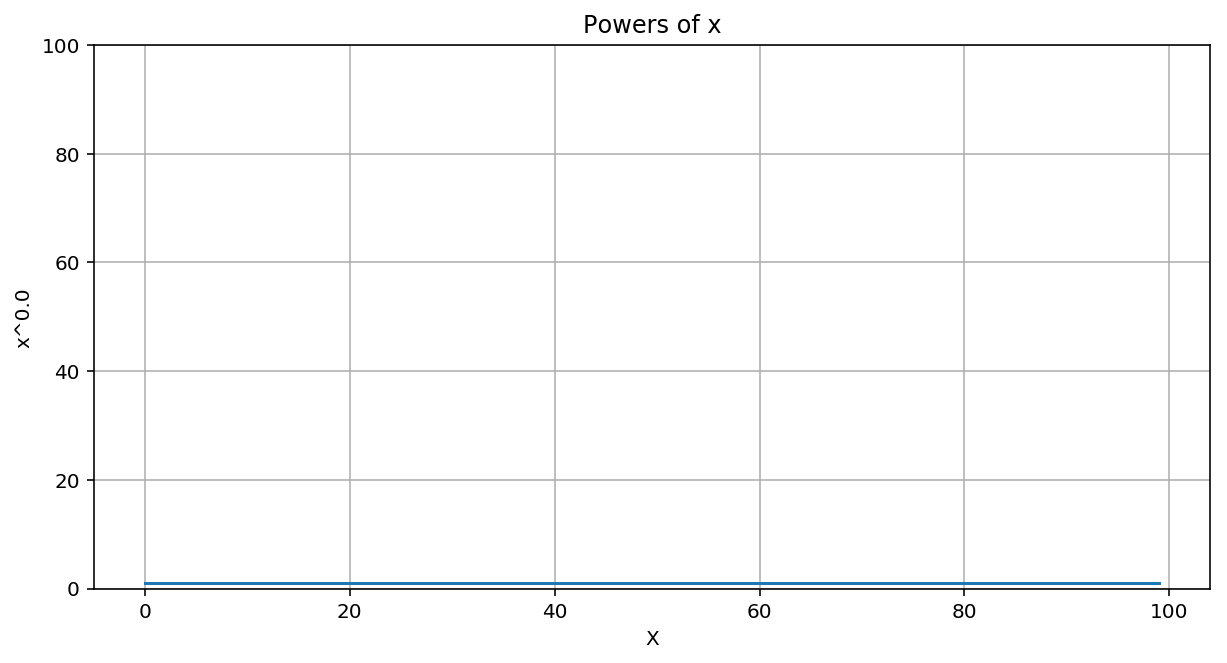

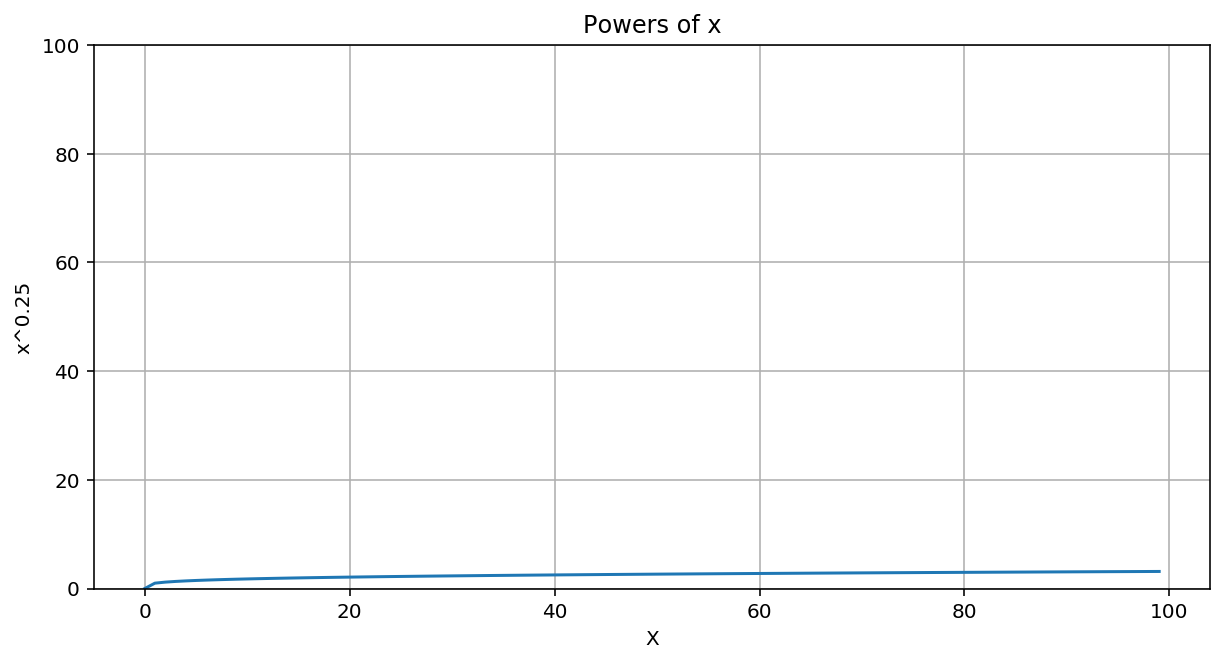

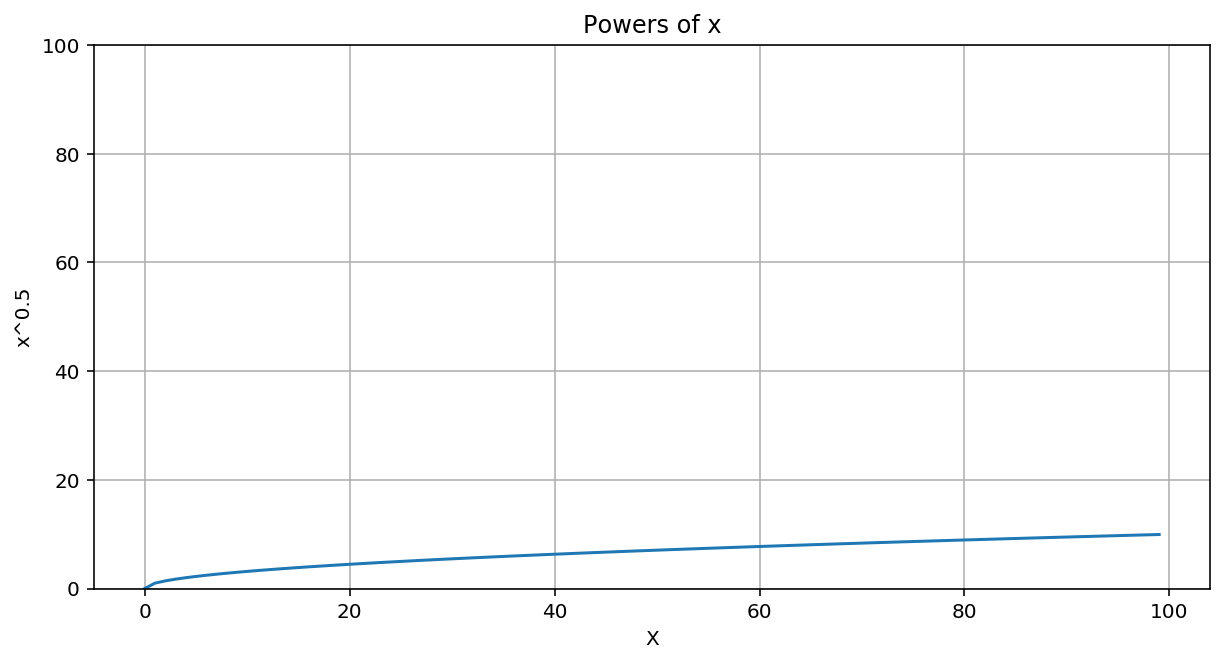

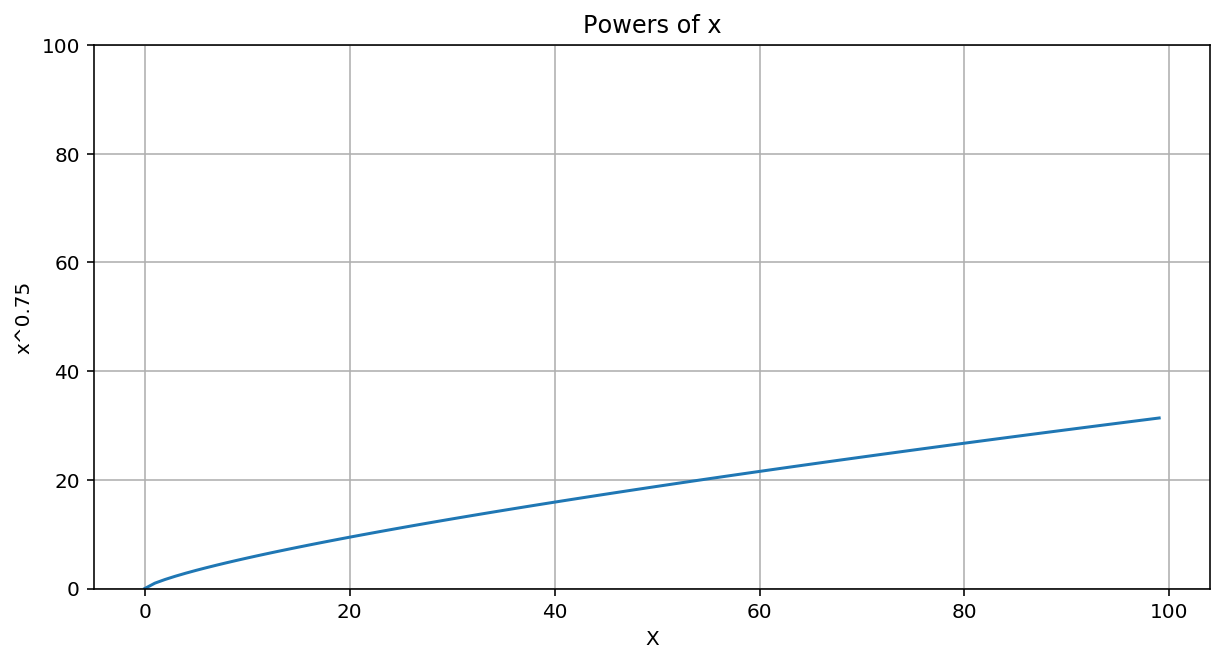

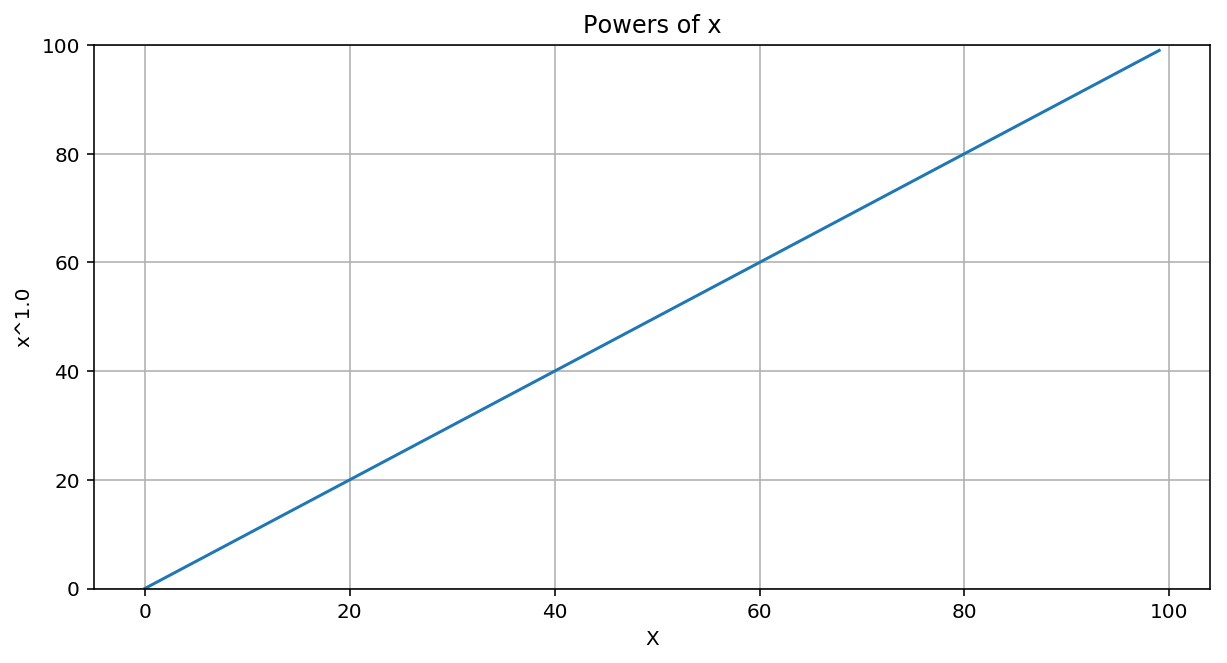

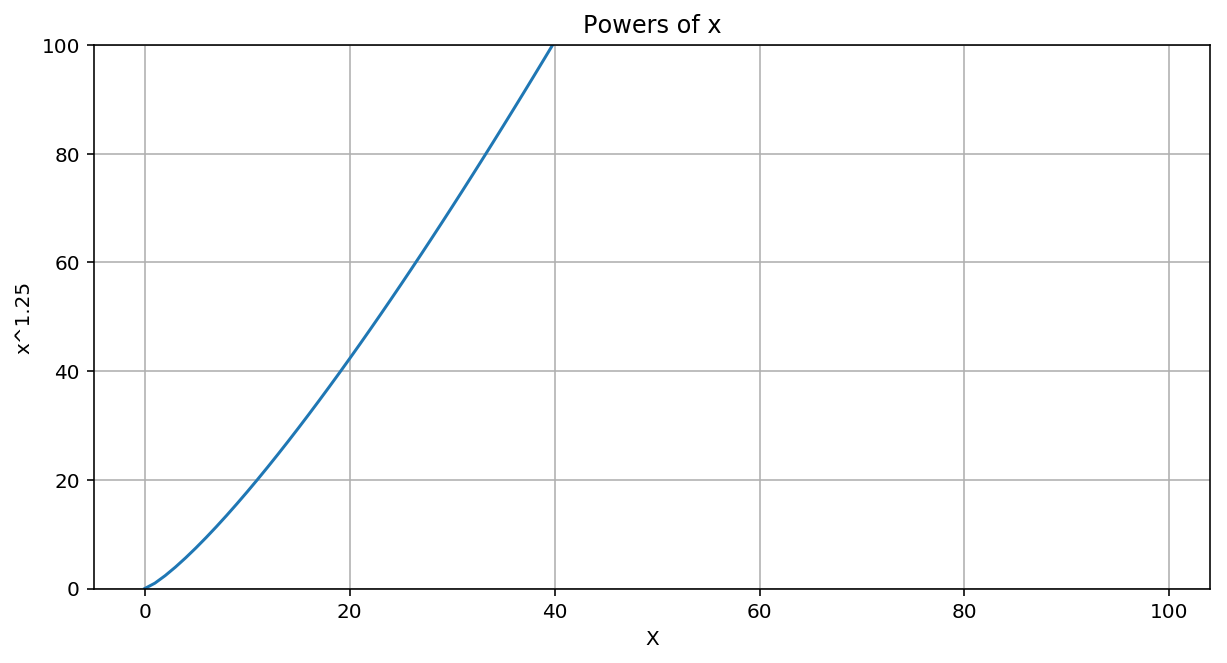

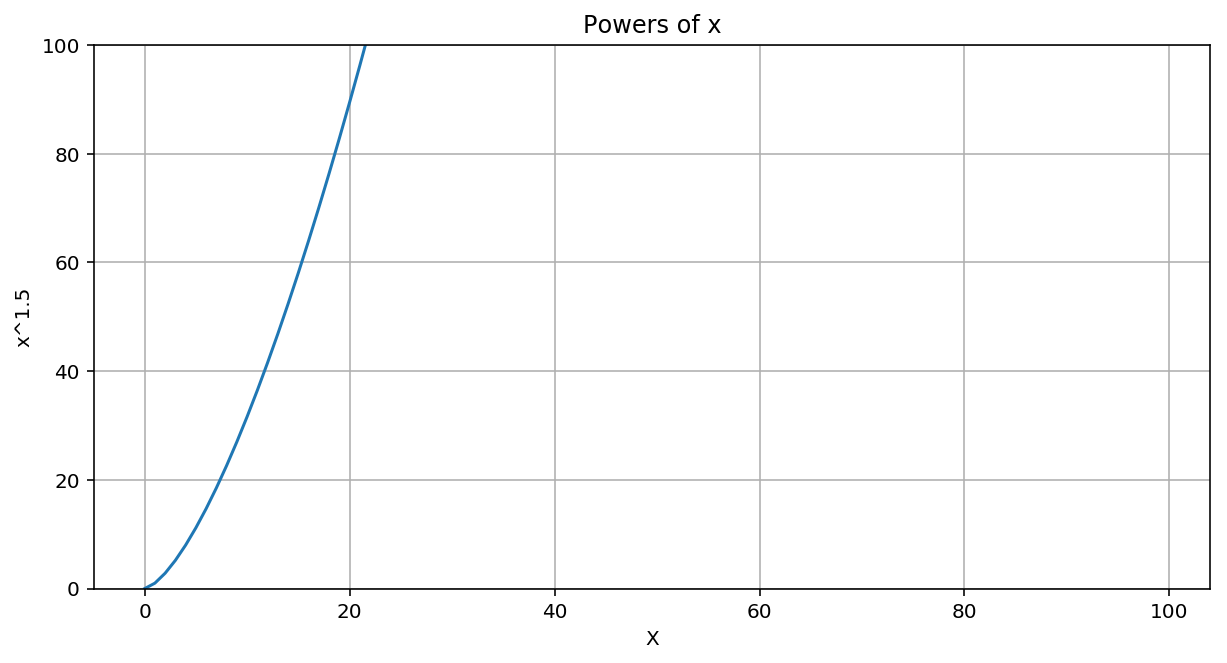

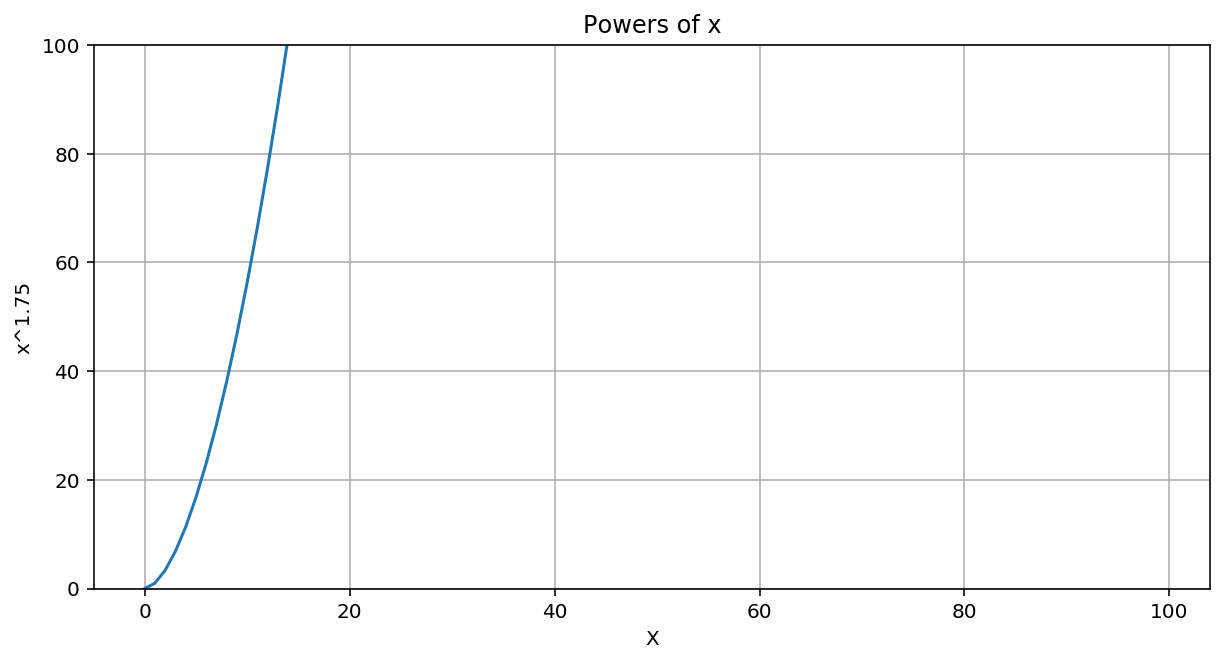

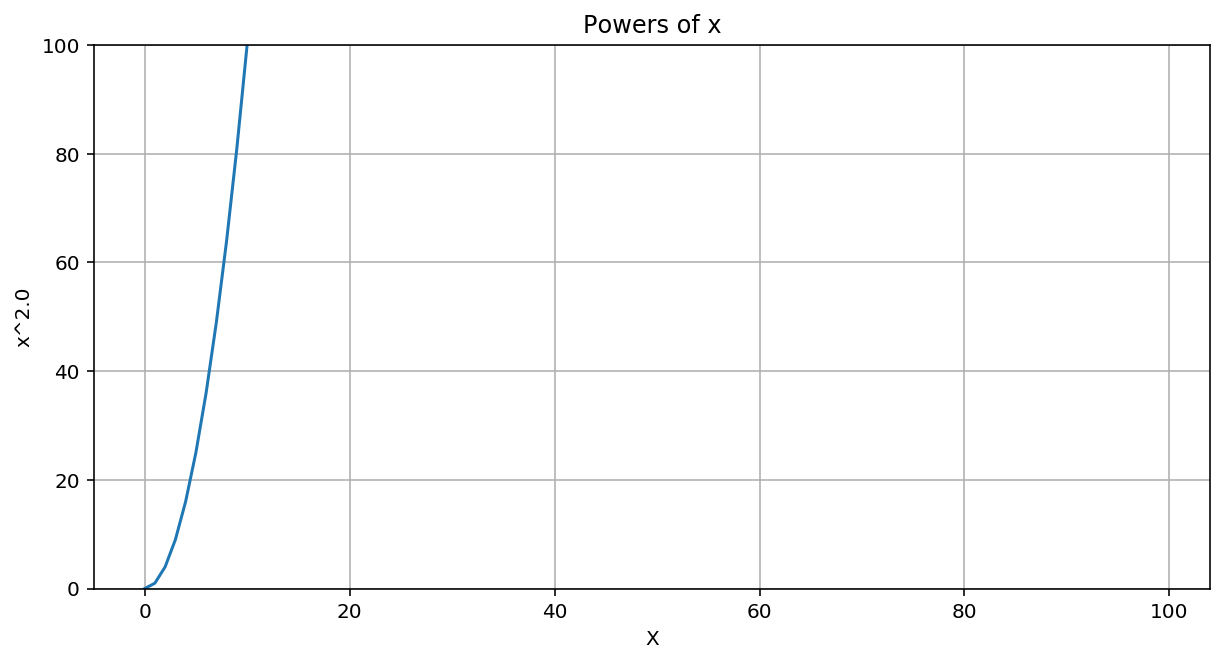

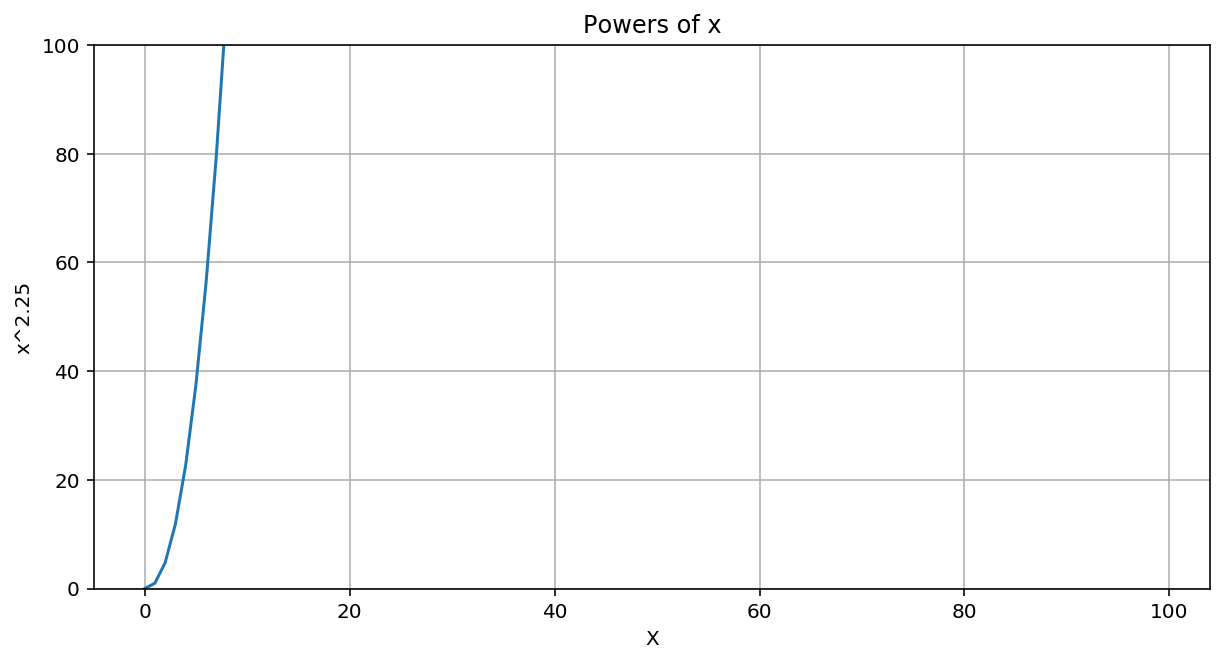

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

def plot_for_offset(power, y_max):
    # Data for plotting
    t = np.arange(0.0, 100, 1)
    s = t**power

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(t, s)
    ax.grid()
    ax.set(xlabel='X', ylabel='x^{}'.format(power),
           title='Powers of x')

    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    ax.set_ylim(0, y_max)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./powers.gif', [plot_for_offset(i/4, 100) for i in range(10)], fps=2)